In [1]:
# Imported necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.model_selection import TimeSeriesSplit

In [2]:
# Loading the dataset
file_path = "orders_autumn_2020.csv"
orders = pd.read_csv(file_path)

In [3]:
# Data Exploration
print(orders.head())
print(orders.info())
print(orders.describe())

                 TIMESTAMP  \
0  2020-08-01 06:07:00.000   
1  2020-08-01 06:17:00.000   
2  2020-08-01 06:54:00.000   
3  2020-08-01 07:09:00.000   
4  2020-08-01 07:10:00.000   

   ACTUAL_DELIVERY_MINUTES - ESTIMATED_DELIVERY_MINUTES  ITEM_COUNT  USER_LAT  \
0                                                -19              1    60.158   
1                                                 -7              8    60.163   
2                                                -17              4    60.161   
3                                                 -2              3    60.185   
4                                                 -1              2    60.182   

   USER_LONG  VENUE_LAT  VENUE_LONG  ESTIMATED_DELIVERY_MINUTES  \
0     24.946     60.160      24.946                          29   
1     24.927     60.153      24.910                          39   
2     24.937     60.162      24.939                          23   
3     24.954     60.190      24.911                          28 

In [4]:
# Feature Engineering
orders['TIMESTAMP'] = pd.to_datetime(orders['TIMESTAMP'])
orders['day_of_week'] = orders['TIMESTAMP'].dt.dayofweek
orders['hour_of_day'] = orders['TIMESTAMP'].dt.hour
orders['delivery_time_difference'] = orders['ACTUAL_DELIVERY_MINUTES'] - orders['ESTIMATED_DELIVERY_MINUTES']
orders['date'] = orders['TIMESTAMP'].dt.day
orders['hour'] = orders['TIMESTAMP'].dt.hour
orders['day_name'] = orders['TIMESTAMP'].dt.day_name()

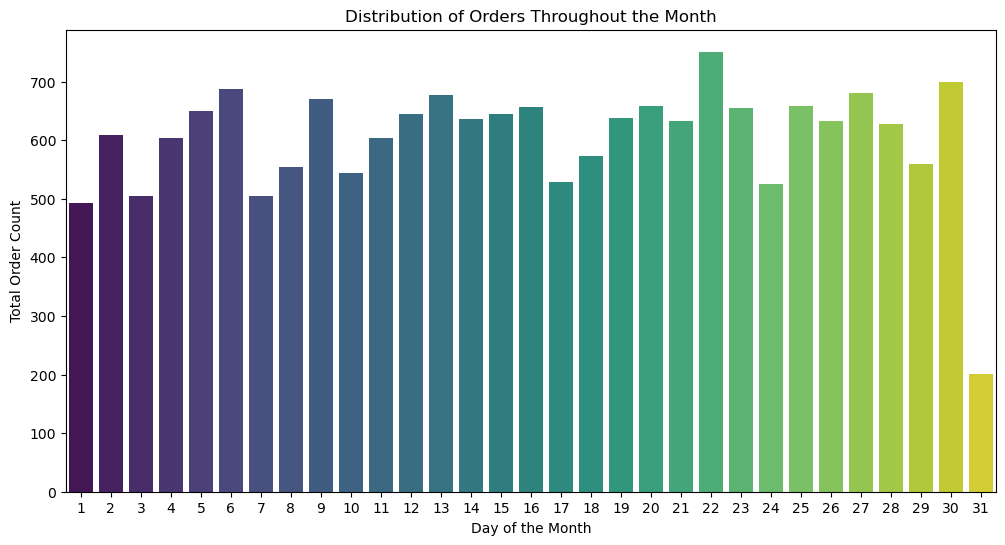

In [5]:
# Creates plot distribution of orders throughout the month
plt.figure(figsize=(12, 6))
sns.countplot(x='date', data=orders, palette='viridis')
plt.title('Distribution of Orders Throughout the Month')
plt.xlabel('Day of the Month')
plt.ylabel('Total Order Count')
plt.savefig('orders_distribution_month.png')
plt.show()

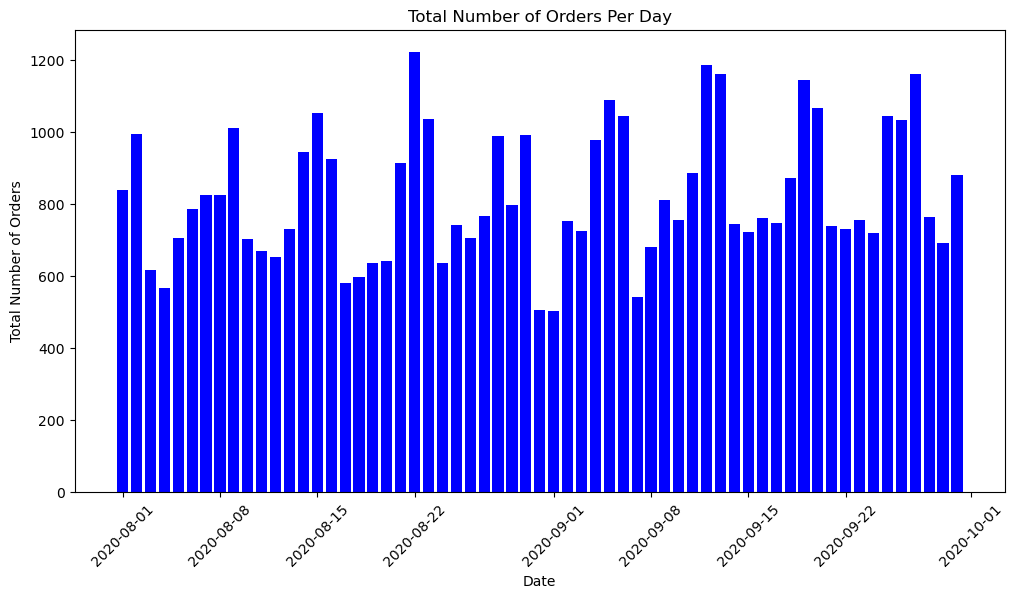

In [6]:
# Extract day from timestamp and create a new column
orders['OrderDay'] = orders['TIMESTAMP'].dt.date

# Calculate the total number of orders per day
daily_orders = orders.groupby('OrderDay')['ITEM_COUNT'].sum().reset_index()

# Plot the total number of orders per day
plt.figure(figsize=(12, 6))
plt.bar(daily_orders['OrderDay'], daily_orders['ITEM_COUNT'], color='blue')
plt.title('Total Number of Orders Per Day')
plt.xlabel('Date')
plt.ylabel('Total Number of Orders')
plt.xticks(rotation=45)
plt.savefig('total_numbers_of_orders_plot.png')
plt.show()

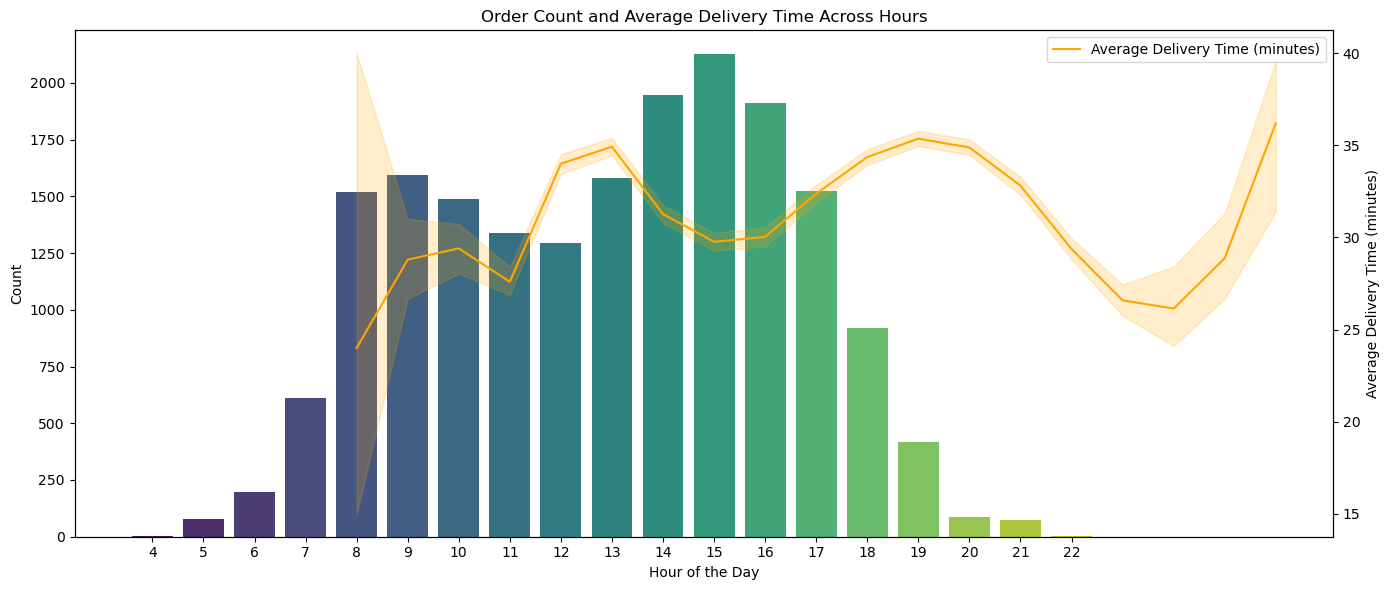

In [7]:
plt.figure(figsize=(14, 6))

# Plot for amount of orders per hour
sns.countplot(x='hour', data=orders, palette='viridis', label='Order Count')
plt.title('Order Count and Average Delivery Time Across Hours')
plt.xlabel('Hour of the Day')
plt.ylabel('Count')

# A secondary Y-axis for the average time of the deliveries.
ax2 = plt.gca().twinx()
sns.lineplot(x='hour', y='ACTUAL_DELIVERY_MINUTES', data=orders, color='orange', label='Average Delivery Time (minutes)')
ax2.set_ylabel('Average Delivery Time (minutes)')

plt.legend(loc='upper left')
ax2.legend(loc='upper right')

plt.tight_layout()
plt.savefig('combined_plot.png')
plt.show()

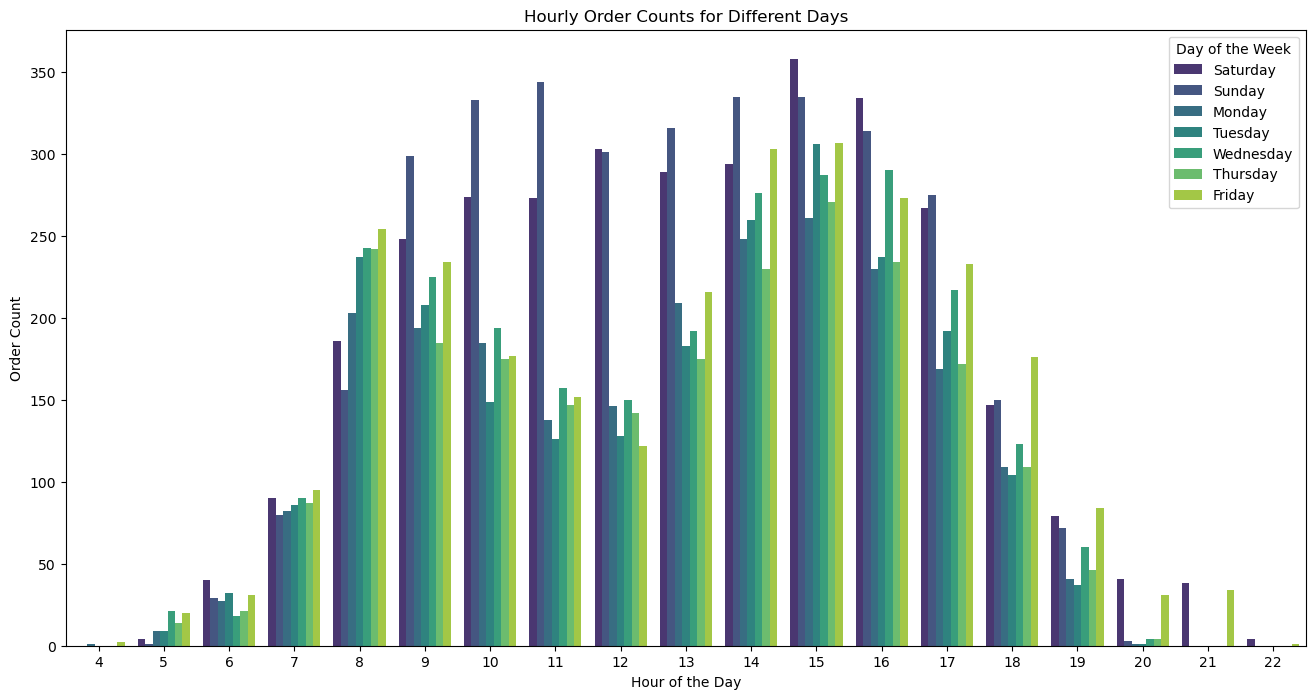

In [8]:
# Separate plots for different days
plt.figure(figsize=(16, 8))
sns.countplot(x='hour', hue='day_name', data=orders, palette='viridis')
plt.title('Hourly Order Counts for Different Days')
plt.xlabel('Hour of the Day')
plt.ylabel('Order Count')
plt.legend(title='Day of the Week')
plt.savefig('hourly_order_count_plot.png')
plt.show()

In [9]:
# Choosinglevant features
features = ['hour_of_day', 'day_of_week', 'USER_LAT', 'USER_LONG', 'VENUE_LAT', 'VENUE_LONG', 'CLOUD_COVERAGE', 'TEMPERATURE', 'WIND_SPEED', 'PRECIPITATION']

# Handle missing values
orders[features] = orders[features].fillna(orders[features].mean())

# Target variable
target = 'ITEM_COUNT'

# Train-test split with time-based validation
X_train, X_test, y_train, y_test = train_test_split(orders[features], orders[target], test_size=0.2, shuffle=False)

# Random Forest Regression model
rf_model = RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42)

tscv = TimeSeriesSplit(n_splits=5)

# Train and evaluate the model
for train_index, test_index in tscv.split(X_train):
    X_train_fold, X_val_fold = X_train.iloc[train_index], X_train.iloc[test_index]
    y_train_fold, y_val_fold = y_train.iloc[train_index], y_train.iloc[test_index]

    rf_model.fit(X_train_fold, y_train_fold)
    predictions = rf_model.predict(X_val_fold)

    mse = mean_squared_error(y_val_fold, predictions)
    mae = mean_absolute_error(y_val_fold, predictions)

    print(f'Mean Squared Error: {mse}, Mean Absolute Error: {mae}')

# Predictions on the test set
test_predictions = rf_model.predict(X_test)

# Evaluate the model
test_mse = mean_squared_error(y_test, test_predictions)
test_mae = mean_absolute_error(y_test, test_predictions)

print(f'Test Mean Squared Error: {test_mse}, Test Mean Absolute Error: {test_mae}')

Mean Squared Error: 3.462401440017551, Mean Absolute Error: 1.5406570576482126
Mean Squared Error: 3.4756060138579508, Mean Absolute Error: 1.549414011635555
Mean Squared Error: 3.486573925170479, Mean Absolute Error: 1.5429292241547057
Mean Squared Error: 3.285402912205722, Mean Absolute Error: 1.5007624789281615
Mean Squared Error: 3.4869954284658857, Mean Absolute Error: 1.529242054603078
Test Mean Squared Error: 3.4509621338055148, Test Mean Absolute Error: 1.5215983911400255


In [10]:
# Check if the 'delivery_time_difference' column exists
if 'delivery_time_difference' not in orders.columns:
    # If not, create the column
    orders['delivery_time_difference'] = orders['ACTUAL_DELIVERY_MINUTES'] - orders['ESTIMATED_DELIVERY_MINUTES']

In [11]:
# Separate features and target variable
X = orders[['ITEM_COUNT', 'USER_LAT', 'USER_LONG', 'VENUE_LAT', 'VENUE_LONG', 'CLOUD_COVERAGE', 'TEMPERATURE', 'WIND_SPEED', 'PRECIPITATION']]
y = orders['delivery_time_difference']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create a pipeline with imputation and linear regression
model = make_pipeline(SimpleImputer(strategy='mean'), LinearRegression())

# Train the model
model.fit(X_train, y_train)

# Make predictions on the test set
predictions = model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, predictions)
print(f'Mean Squared Error: {mse}')

Mean Squared Error: 79.46777263276682


In [12]:
# Select features for modeling
features = ['ITEM_COUNT', 'USER_LAT', 'USER_LONG', 'VENUE_LAT', 'VENUE_LONG', 'CLOUD_COVERAGE', 'TEMPERATURE', 'WIND_SPEED', 'PRECIPITATION']

# Drop rows with missing values in the selected features
model_data = orders.dropna(subset=features + ['delivery_time_difference'])

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(model_data[features], model_data['delivery_time_difference'], test_size=0.2, random_state=42)

# Train the Linear Regression model
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

# Make predictions on the test set
lr_predictions = lr_model.predict(X_test)

# Evaluate the model
lr_mse = mean_squared_error(y_test, lr_predictions)
print(f"Linear Regression Mean Squared Error: {lr_mse}")
lr_mae = mean_absolute_error(y_test, lr_predictions)
print(f"Linear Regression Mean Absolute Error: {lr_mae}")

Linear Regression Mean Squared Error: 79.46777263276682
Linear Regression Mean Absolute Error: 7.090048023290165


In [13]:
# Train the Random Forest Regression model
rf_model = RandomForestRegressor()
rf_model.fit(X_train, y_train)

# Make predictions on the test set
rf_predictions = rf_model.predict(X_test)

# Evaluate the model
rf_mse = mean_squared_error(y_test, rf_predictions)
print(f"Random Forest Regression Mean Squared Error: {rf_mse}")
rf_mae = mean_absolute_error(y_test, rf_predictions)
print(f"Random Forest Regression Mean Absolute Error: {rf_mae}")

Random Forest Regression Mean Squared Error: 83.00976025996201
Random Forest Regression Mean Absolute Error: 7.24204400498842
